In [1]:
import numpy as np
import keras
import os
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import pickle

In [3]:
!ls ../train/joints/

leapJoints  mpJoints  myjoints.png  readme.md


In [4]:
#leap numerical data directory
data_dir = "../train/joints/leapJoints"

In [5]:
fileNames = [file for file in 
os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, file))]
classes = list(sorted(set([x[0] for x in fileNames])))
Ys = [classes.index(x[0]) for x in fileNames]

In [6]:
def unpickle(filepath):
    with open(filepath, "rb") as input_file:
        e = pickle.load(input_file)
    return e

def train_val_test_split(dataX, dataY, train = 0.7, val = 0.2, test=0.1):
    x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1 - train)

    # test is now 10% of the initial data set
    # validation is now 15% of the initial data set
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test/(test + val)) 

    return x_train, x_val, x_test, y_train, y_val, y_test

In [7]:
x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(fileNames, Ys)

In [39]:
# dict(zip(x_train, y_train))

In [22]:
class JointDataGenerator(keras.utils.all_utils.Sequence):
    def __init__(self, IDs, labels,data_directory, batch_size=4, dim=(21,21), n_classes=11, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.IDs = IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.indexes = []
        self.data_dir = data_directory
        self.update_indexes()
        
    def update_indexes(self):
        self.indexes = np.arange(len(self.IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __len__(self): 
        # will always omit last batch of data 
        # so the train dataset will always be lower than expected
        return int(np.floor(len(self.IDs) / self.batch_size))
    
    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        list_IDs_temp = [self.IDs[k] for k in indexes]
        
        X,y = self.__data_generation(list_IDs_temp)
        
        return X,y

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim, 1))
        y = np.empty((self.batch_size), dtype=int)
        
        
        for i, ID in enumerate(list_IDs_temp):
            data = unpickle(f"{self.data_dir}/{ID}")
            do_the_thing(data)
            y[i] = self.labels[ID]
            
        return X, to_categorical(y, num_classes = self.n_classes)

In [21]:
train_generator = JointDataGenerator(x_train[:1], dict(zip(x_train, y_train)), data_dir)

In [23]:
def do_the_thing(data):
    print(data)

In [42]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'. """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [74]:
data = np.zeros((max(x.shape), max(x.shape)))
for i_ind, row_i in enumerate(x):
    for j_ind, row_j in enumerate(x):
        data[i_ind][j_ind]=angle_between(row_i, row_j)

In [112]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)) #trzeba chyba swój napisać, bo max = arccos(-1) a min = arccos(1)
tmp = data.reshape(-1,1)
scaler.fit(tmp)
scaled = scaler.fit_transform(tmp).reshape(data.shape)

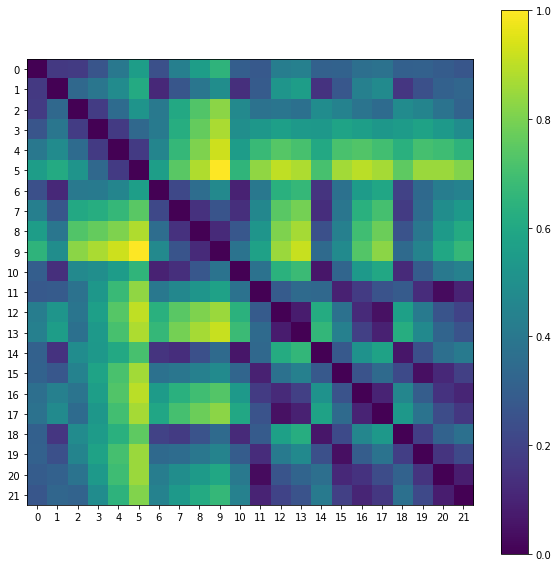

In [124]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots( figsize=(10,10))
shw = ax.imshow(scaled)

# make bar
bar = plt.colorbar(shw)
  
# show plot with labels
plt.xticks(np.arange(0,22,1))
plt.yticks(np.arange(0,22,1))
plt.show()

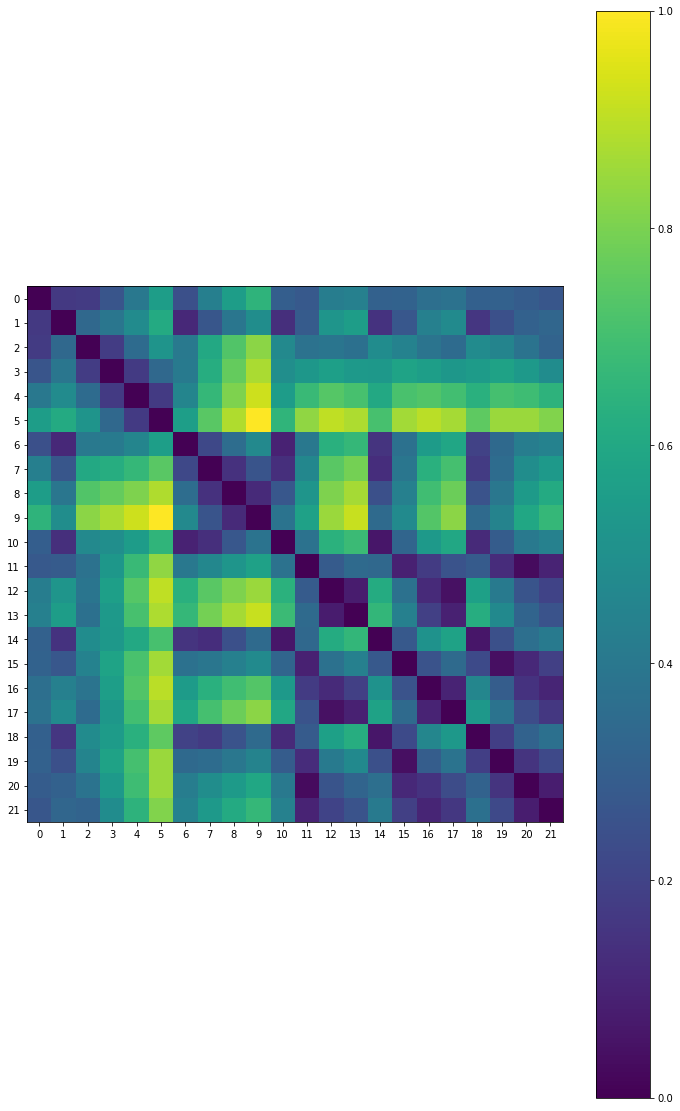

In [118]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,20))
shw = plt.imshow(scaled)
plt.colorbar(shw)
plt.show()

In [100]:
scaled

array([[0.00000000e+00, 1.65238626e-01, 1.74997512e-01, 2.64803353e-01,
        3.99996493e-01, 5.55953731e-01, 2.45886977e-01, 4.32379033e-01,
        5.55044949e-01, 6.51500609e-01, 2.97216259e-01, 2.79337369e-01,
        4.22397167e-01, 4.37231196e-01, 3.11367742e-01, 3.15696018e-01,
        3.66805369e-01, 3.78461039e-01, 3.08358274e-01, 3.12273779e-01,
        2.92482189e-01, 2.68037533e-01],
       [1.65238626e-01, 0.00000000e+00, 3.39537094e-01, 3.91660752e-01,
        4.84113066e-01, 6.13155923e-01, 1.15227302e-01, 2.67621839e-01,
        3.90968379e-01, 4.91471342e-01, 1.34137238e-01, 2.86651092e-01,
        5.22135182e-01, 5.56649047e-01, 1.47440505e-01, 2.69981195e-01,
        4.34592705e-01, 4.80217065e-01, 1.56817531e-01, 2.45822152e-01,
        3.10903503e-01, 3.30162987e-01],
       [1.74997512e-01, 3.39537094e-01, 2.16694835e-08, 1.78683809e-01,
        3.47777800e-01, 5.15771901e-01, 4.05648627e-01, 6.05083940e-01,
        7.29996437e-01, 8.25821306e-01, 4.69050012e-01

In [92]:
tmp.reshape(22,22).shape

(22, 22)

In [31]:
x = [[0.89489048,0.96987676,0.67370659],
 [0.72482029 ,0.64846226,0.741638  ],
 [0.73906736 ,1.        ,0.3704638 ],
 [0.38738733 ,0.8590677  ,0.35196894],
 [0.16357041 ,0.73907104 ,0.34263184],
 [0.         ,0.67082815 ,0.33424598],
 [0.48625168 ,0.53373125, 0.69293411],
 [0.43191497 ,0.26097773 ,0.6958735 ],
 [0.41382668 ,0.10730074 ,0.65796632],
 [0.40801725 ,0.         ,0.60995803],
 [0.63085603 ,0.51209836 ,0.84881782],
 [0.68150761 ,0.3449535  ,0.3181374 ],
 [0.77436214 ,0.44975495 ,0.05230722],
 [0.82487199 ,0.56044437 ,0.        ],
 [0.79646909 ,0.52497414,0.95921612],
 [0.84375522 ,0.35823076, 0.4840297 ],
 [0.89520145 ,0.4573525  ,0.19185348],
 [0.91881786 ,0.56927343 ,0.11095688],
 [0.96145479 ,0.54155565 ,1.        ],
 [0.95780457 ,0.41185682 ,0.61544989],
 [0.97983667 ,0.48952921 ,0.41514531],
 [1.         ,0.59533844 ,0.35599307]]
x = np.array(x)

In [24]:
X, _ = train_generator.__getitem__(0)

[[0.89489048 0.96987676 0.67370659]
 [0.72482029 0.64846226 0.741638  ]
 [0.73906736 1.         0.3704638 ]
 [0.38738733 0.8590677  0.35196894]
 [0.16357041 0.73907104 0.34263184]
 [0.         0.67082815 0.33424598]
 [0.48625168 0.53373125 0.69293411]
 [0.43191497 0.26097773 0.6958735 ]
 [0.41382668 0.10730074 0.65796632]
 [0.40801725 0.         0.60995803]
 [0.63085603 0.51209836 0.84881782]
 [0.68150761 0.3449535  0.3181374 ]
 [0.77436214 0.44975495 0.05230722]
 [0.82487199 0.56044437 0.        ]
 [0.79646909 0.52497414 0.95921612]
 [0.84375522 0.35823076 0.4840297 ]
 [0.89520145 0.4573525  0.19185348]
 [0.91881786 0.56927343 0.11095688]
 [0.96145479 0.54155565 1.        ]
 [0.95780457 0.41185682 0.61544989]
 [0.97983667 0.48952921 0.41514531]
 [1.         0.59533844 0.35599307]]


IndexError: index 32 is out of bounds for axis 1 with size 11

In [187]:
x = unpickle(f"{data_dir}/{x_train[0]}")

In [ ]:
generalnie muszę teraz ogarnąć jak się liczy kąt między dwoma wektorami

In [188]:
x

array([[9.77353026e-01, 9.12429555e-01, 5.17594024e-01],
       [8.50896902e-01, 3.27361548e-01, 6.50511974e-01],
       [7.70488774e-01, 1.00000000e+00, 7.93013731e-01],
       [4.66910645e-01, 5.79829403e-01, 6.88558188e-01],
       [2.51624507e-01, 2.96386939e-01, 6.56227410e-01],
       [1.18653321e-01, 9.85007863e-02, 5.70685248e-01],
       [7.36898549e-01, 8.55170946e-02, 1.00000000e+00],
       [3.65013258e-01, 4.76921167e-02, 7.67009179e-01],
       [1.59383429e-01, 5.64830068e-02, 6.22457620e-01],
       [1.59404918e-02, 7.26942086e-02, 5.16287289e-01],
       [8.47494682e-01, 5.01819946e-02, 7.45409851e-01],
       [4.20221411e-01, 1.70418248e-04, 5.23288480e-01],
       [1.67102241e-01, 0.00000000e+00, 3.91514245e-01],
       [0.00000000e+00, 9.13058222e-03, 3.04461489e-01],
       [9.46298913e-01, 8.93919012e-02, 4.71219240e-01],
       [5.46575454e-01, 3.26223006e-02, 2.85147797e-01],
       [2.96220947e-01, 2.68280802e-02, 1.73498985e-01],
       [1.27098500e-01, 3.23943